## Setting Up

### Importing libs

In [369]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
import geog
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split
import folium
import altair as alt

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

from folium.plugins import HeatMap

### Defining Consts

In [370]:
### Consts
datapath = '../rawdata/sensors/'
metadata_file = datapath + 'nodes.txt'
preprocessed_path = '../data/preprocessed/noisePerLocation/'

### Loading datasets

In [387]:
## Loading 311
noiseComplaints = pd.read_pickle('../data/311/311.pkl')
noiseComplaints = gpd.GeoDataFrame(noiseComplaints, crs={'init' : 'epsg:4326'}, geometry='geometry')
noiseComplaints = noiseComplaints['2018-01-01':'2018-12-31']

## Loading taxi regions
taxi_regions = gpd.read_file('zip://../assets/taxi_zones.zip')
taxi_regions = taxi_regions.to_crs({'init':'epsg:3857'})

## Merging datasets

Selecting sensors with the best data quality: Less missing data and outliers.

In [425]:
## Using sensors with the best data quality
# selectedsensors = [ "sonycnode-b827eb0fedda.sonyc",
# #                     "sonycnode-b827eb42bd4a.sonyc",
#                     "sonycnode-b827eb44506f.sonyc",
#                     "sonycnode-b827eb73e772.sonyc",
#                     "sonycnode-b827eb84deb5.sonyc",
#                     "sonycnode-b827ebb40450.sonyc",
                   
#                     "sonycnode-b827eb0d8af7.sonyc",
#                     "sonycnode-b827eb122f0f.sonyc"]


selectedsensors = [ "sonycnode-b827eb0d8af7.sonyc",
                    "sonycnode-b827eb5d1714.sonyc",
                    "sonycnode-b827eb122f0f.sonyc",
                    "sonycnode-b827eb2a1bce.sonyc"]

Getting only sensors in Manhattan

In [424]:
manhattan_sensors[manhattan_sensors['LocationID'] == 162]

,geometry,sensorID,index_right,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
21,POINT (-8234900.853602478 4975717.103636416),sonycnode-b827eb5d1714.sonyc,161,162,0.03527,0.000048,Midtown East,162,Manhattan


In [411]:
sensors_geodf = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})

f = open(metadata_file)
for line in f:
    s, lat, lon = line.split(' ')
    
    lat = float(lat)
    lon = float(lon)
    
    ## adding sensor to geodataframe
    sensor_point = shapely.geometry.Point(lon, lat)
    sensors_geodf = sensors_geodf.append({'sensorID': s, 'geometry':sensor_point}, ignore_index=True)
    
    
sensors_geodf = sensors_geodf.to_crs({'init':'epsg:3857'})


# folium_map = folium.Map(location=[40.742, -73.956], zoom_start=12, tiles="cartodbpositron")
# plotPolygon(folium_map, sensors_geodf[ sensors_geodf['sensorID'].isin(selectedsensors)])
# display(folium_map)

# ## join taxi regions with sensors
manhattan_regions = taxi_regions[taxi_regions['borough'] == 'Manhattan']
manhattan_sensors = gpd.tools.sjoin(sensors_geodf, manhattan_regions, how='inner', op="within")

# ## closing file
f.close()

Filtering all the 311 complaints within a range of the sensor.

In [426]:
unique_dataset = pd.DataFrame()
dataset = {}

f = open(metadata_file)
for line in f:
    
    # reading sensor metadata
    s, lat, lon = line.split(' ')
    lat = float(lat)
    lon = float(lon)
    
    if s in selectedsensors:
        
        print('sensorID: ', s)
        dataset[s] = {}

        # creating empty timeseries
        df_timeseries = pd.DataFrame()
        df_timeseries['datetime'] = pd.date_range('2018-01-01', '2018-12-31', freq="1d")
        df_timeseries.set_index(['datetime'], inplace = True)

        # reading sensor data
        sensorData = pd.read_pickle(datapath + s + '.pkl')
        sensorData['dbas'] = sensorData['sum'] / sensorData['count']
        sensorData = sensorData.resample('1D').agg({'dbas': 'mean'})
        
        # filtering noise complaints
        noiseComplaints_temp = noiseComplaints.to_crs({'init':'epsg:3857'})
        noiseComplaints_temp = spatialJoin(lat, lon, s, noiseComplaints_temp)
        dataset[s]['nComplaints'] = noiseComplaints_temp.shape[0]
        noiseComplaints_temp = noiseComplaints_temp.resample('1D').agg({'Descriptor': 'count'})
        noiseComplaints_temp.rename({'Descriptor':'noise'}, inplace=True)

        ## adding noise and dbas to the dataframe
        df_timeseries['noise'] = noiseComplaints_temp
        df_timeseries['dbas'] = sensorData[['dbas']]

        ## adding to the dictionary
        df_timeseries = df_timeseries.dropna(subset=['dbas'])
        df_timeseries['noise'].fillna(0, inplace=True)
        dataset[s]['training'] = df_timeseries.dropna(subset=['dbas'])
        
        unique_dataset = unique_dataset.append(dataset[s]['training'])

sensorID:  sonycnode-b827eb0d8af7.sonyc
sensorID:  sonycnode-b827eb122f0f.sonyc
sensorID:  sonycnode-b827eb2a1bce.sonyc
sensorID:  sonycnode-b827eb5d1714.sonyc


## Running the regressor

For each set of 311 complaints, we train a Gaussian Regresor model

In [427]:
# for sensor in dataset:
    
errorDF = pd.DataFrame(columns=['actual', 'predicted', 'error', 'std_dev'])

## defining kernel
kernel_regressor = DotProduct() + WhiteKernel()

## defining regressor
gp_regressor = GaussianProcessRegressor(kernel=kernel_regressor,random_state=0)

## setting the time frame
#     dataset[sensor]['training'] = dataset[sensor]['training']['2018-01-01':'2018-06-01']

## spliting into features and results
# X = dataset[sensor]['training'][['noise']]
# y = dataset[sensor]['training'][['dbas']]

X = unique_dataset[['noise']]
y = unique_dataset[['dbas']]

## splitting into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

## training
gp_regressor = gp_regressor.fit(X_train, y_train)

## predicting
y_pred, y_pred_std = gp_regressor.predict(X_test, return_std=True)

y_test['predicted'] = y_pred
y_test['std_dev'] = y_pred_std

# dataset[sensor]['summary'] = y_test
# dataset[sensor]['regressor'] = gp_regressor

unique_regressor = gp_regressor
unique_summary = y_test

/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/jlrulff/anaconda3/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs

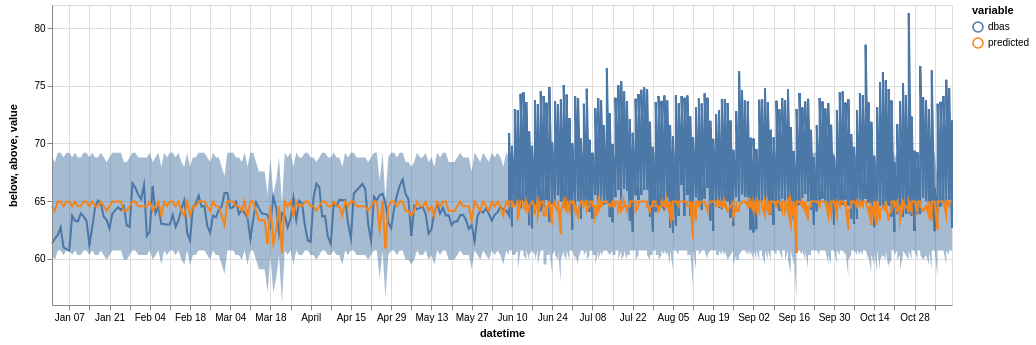

In [393]:
# for sensor in dataset.keys():
    

# plot_poster = dataset[sensor]['summary']
# plot_poster['below'] = plot_poster['predicted'] - plot_poster['std_dev']
# plot_poster['above'] = plot_poster['predicted'] + plot_poster['std_dev']

# plot_timeseries(plot_poster[['dbas', 'predicted']], plot_poster[['below', 'above']], 'title')

plot_poster = unique_summary
plot_poster['below'] = plot_poster['predicted'] - plot_poster['std_dev']
plot_poster['above'] = plot_poster['predicted'] + plot_poster['std_dev']

plot_timeseries(plot_poster[['dbas', 'predicted']], plot_poster[['below', 'above']], 'title')

Calculating the error for each trained model:

In [394]:
## dataframe to pick the least error
models_performance = pd.DataFrame()

for sensor in dataset:
    ## calculating error for each row
    dataset[sensor]['summary']['error'] = abs(dataset[sensor]['summary']['dbas'] - dataset[sensor]['summary']['predicted'])
    
    ## overall error
    overall_error = dataset[sensor]['summary']['error'].mean()
    nOfComplaints = dataset[sensor]['nComplaints']
    
    models_performance = models_performance.append({
        'sensor': sensor,
        'error': overall_error,
        'complaints': nOfComplaints}, ignore_index = True)

KeyError: 'summary'

In [ ]:
# models_performance.rename({'error':'RMSE'}, inplace=True)
models_performance

In [428]:
summaryDF_errorMap_daily = pd.DataFrame()

regions = taxi_regions[taxi_regions['borough'] == 'Manhattan']['LocationID'].values

# for sensor in dataset:
    
#     print(sensor)
    
#     regressor = dataset[sensor]['regressor']
regressor = unique_regressor

for region in regions:

    print(region)

    currentDF = pd.DataFrame()

    currentRegion = taxi_regions[taxi_regions['LocationID'] == region]
    region_geometry = taxi_regions[taxi_regions['LocationID'] == region]['geometry'].values[0] 

    ## getting all noise complaints in the given region
#     noiseComplaints_temp = noiseComplaints.to_crs({'init':'epsg:3857'})
#     noiseComplaints_temp = gpd.tools.sjoin(noiseComplaints_temp, currentRegion, how='inner', op="within")
#     noiseComplaints_temp = noiseComplaints_temp.resample('H').agg({'Descriptor': 'count'})
#     noiseComplaints_temp.rename(columns={'Descriptor':'noise'}, inplace=True)

    currentPath = preprocessed_path + str(region) + '.csv'
    noiseComplaints_temp = pd.read_csv(currentPath, index_col=0)
    noiseComplaints_temp = noiseComplaints_temp.reset_index()
    noiseComplaints_temp['index'] = pd.to_datetime(noiseComplaints_temp['index'])
    noiseComplaints_temp.set_index('index', inplace=True)

    if(noiseComplaints_temp.shape[0] > 0):

        # adding noise to a single df
        currentDF = noiseComplaints_temp

        # adding cos and sin to the dataframe
        currentDF['hour'] = currentDF.index.hour
        currentDF['weekday'] = currentDF.index.weekday

        ## predicting
        X = currentDF[['noise']]
        y_pred, y_std = regressor.predict(X, return_std=True)

        currentDF['std_dev'] = y_std
        currentDF['pred'] = y_pred

        for day in range(0,7):

            current_weekday_df = currentDF[currentDF['weekday'] == day]

            summaryDF_errorMap_daily = summaryDF_errorMap_daily.append(
                {'region':region, 
                 'model':sensor,
                 'weekday':day,
                 'std_dev_mean':current_weekday_df['std_dev'].mean(),
                 'std_dev_range':(current_weekday_df['std_dev'].max() - current_weekday_df['std_dev'].min()),
                 'geometry': region_geometry
                }, ignore_index=True)

4
12
13
24
41
42
43
45
48
50
68
74
75
79
87
88
90
100
103
103
103
107
113
114
116
120
125
127
128
137
140
141
142
143
144
148
151
152
153
158
161
162
163
164
166
170
186
194
202
209
211
224
229
230
231
232
233
234
236
237
238
239
243
244
246
249
261
262
263


In [422]:
manhattan_sensors['LocationID'].unique()

array([113, 114,  79, 234, 236, 162, 100, 161, 233, 144,  42])

In [429]:
## filtering only weekend
choropleth = summaryDF_errorMap_daily[summaryDF_errorMap_daily['weekday'] <= 4]
choropleth = choropleth.groupby(['region']).agg({'geometry':'first', 'std_dev_mean':'mean', 'std_dev_range':'mean'})
choropleth = choropleth.reset_index()

# summaryDF_errorMap_daily = summaryDF_errorMap_daily.to_crs({'init': 'epsg:3857'}) 
# summaryDF_errorMap_daily.apply(lambda row: getPolygonsBelow(row, 40.769512), axis=1)

# ## transforming in a geodataframe
choropleth = gpd.GeoDataFrame(choropleth, geometry='geometry', crs={'init':'epsg:3857'})
choropleth['centroid'] = choropleth['geometry'].centroid

choropleth['inside'] = choropleth.apply(lambda row: getPolygonsBelow(row, 40.769512), axis=1)
choropleth = choropleth[ (choropleth['inside'] == True) & (choropleth['region'] != 202.0) & (choropleth['region'] != 140.0)]

# choropleth
# plotting choropleth
folium_map = folium.Map(location=[40.742, -73.956], zoom_start=12, tiles="cartodbpositron")
generateChoropleth(folium_map, choropleth[['geometry', 'region', 'std_dev_mean']], 'region', 'std_dev_mean')
display(folium_map)

folium_map = folium.Map(location=[40.742, -73.956], zoom_start=12, tiles="cartodbpositron")
plotPolygon(folium_map, choropleth[['geometry', 'region']])
display(folium_map)

## Helper Functions

### Processing Functions

In [ ]:
import random
def normalizeArray(value, array_max, array_min):
    
    normalized = (value - array_min) / (array_max - array_min)
    return 1

def randomNum():
    
    return random.uniform(0, 1)

### Geospatial Functions

In [341]:
def spatialJoin_polygon(noiseDF, geometry, locationID, sensorID):
    
    sinpoly = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
    sinpoly = sinpoly.append({'geometry': geometry, 'sensorID':sensorID}, ignore_index=True) 
    sinpoly = sinpoly.to_crs({'init':'epsg:3857'})
    
    plotPolygon(testing_map, sinpoly)
    
#     dataframe = gpd.tools.sjoin(noiseDF, sinpoly, how='inner', op="within")
    
#     return dataframe

def spatialJoin(sensorLat, sensorLon, sensorID, geoDataFrame):
    
    d = 300 # meters
    n_points = 20
    angles = np.linspace(0, 360, n_points)
    center = shapely.geometry.Point(sensorLon, sensorLat)
    polygon = Polygon(geog.propagate(center, angles, d))
    
    sinpoly = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
    sinpoly = sinpoly.append({'geometry': polygon, 'sensorID':sensorID}, ignore_index=True) 
    sinpoly = sinpoly.to_crs({'init':'epsg:3857'})
    
    dataframe = gpd.tools.sjoin(geoDataFrame, sinpoly, how='inner', op="within")
        
    return dataframe

def getPolygonsBelow(row, latitude):
    
    if(row['centroid'].y < 4977950):
        return True
    else:
        return False
#     print(row['centroid'].y )

### Visualization Functions

In [398]:
def plotPolygon(foliumMap, polygondf):
    folium.GeoJson(
        data=polygondf,
        tooltip=folium.GeoJsonTooltip(fields=['region'],
                                              labels=False,
                                              sticky=False)).add_to(foliumMap)                   
                                     
def drawPolygons(foliumMap, polygon, normValue):
    folium.Polygon(polygon, popup='Ross Island Bridge',fill_color='#132b5e').add_to(foliumMap)
    pass

def generateChoropleth(folium_map, geodataframe, indexColumn, colorColumn):
    
    keyString = 'feature.properties.'+indexColumn
    
    folium_map.choropleth(
        geo_data=geodataframe,
        name='choropleth',
        data=geodataframe[[indexColumn, colorColumn]],
        columns=[indexColumn, colorColumn],
        key_on=keyString,
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2
    )

    folium.LayerControl().add_to(folium_map)
    
    return folium_map


def plot_timeseries(pred_timeseries, error_band, title):
    
#     tranforming to long form
    long_form_df = pd.melt(pred_timeseries.reset_index(), id_vars=['datetime'])

    brush = alt.selection(type='interval', encodings=['x'])

#     line = alt.Chart(long_form_df).mark_line().encode(
#         alt.X('datetime', type='temporal', scale={'domain': brush.ref()}),
#         alt.Y('value', type='quantitative', scale=alt.Scale(zero=False)),
#         color='variable'
#     ).properties(
#         width=900
#     )

    line = alt.Chart(long_form_df).mark_line().encode(
        alt.X('datetime', type='temporal'),
#         alt.X('datetime', type='temporal', scale={'domain': brush.ref()}),
        alt.Y('value', type='quantitative', scale=alt.Scale(zero=False)),
        color='variable'
    ).properties(width=900)

#     print(pred_timeseries)
    
    # Configure the confidence interval        
    confidence_interval = alt.Chart(error_band.reset_index()).mark_area(opacity=0.5).encode(
        alt.X('datetime', type='temporal'),
#         alt.X('datetime', type='temporal', scale={'domain': brush.ref()}),
        y='below:Q',
        y2='above:Q').properties(width=900)
    
#     lower = line.properties(
#         height=60
#     ).add_selection(brush)

    upper = confidence_interval + line
#     display(alt.vconcat(upper, lower))
    display(upper)
    
